In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

lm_path = f"./language_modeling.csv"
mcp_path = f"./multiple_choice_prompt.csv"
poe_path = f"./process_of_elimination.csv"
cha_path = f"./channel.csv"
cal_path = f"./calibration.csv"
gen_path = f"./generate_synonyms.csv"
cd_path = f"./contrastive_decoding.csv"
lm_df = pd.read_csv(lm_path)
mcp_df = pd.read_csv(mcp_path)
poe_df = pd.read_csv(poe_path)
cha_df = pd.read_csv(cha_path)
cal_df = pd.read_csv(cal_path)
gen_df = pd.read_csv(gen_path)
cd_df = pd.read_csv(cd_path)


In [2]:
# drop columns should be a list. Use type hints to enforce this.
def process(df, drop_columns=None):
    # get rid of identical rows 
    df = df.drop_duplicates() # is this really necessary?
    # df = df[df["checkpoint"].str.startswith("google/flan-t5")]
    # remove the seed column and batch_size column
    if isinstance(drop_columns, list):
        drop_columns += ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    else:
        drop_columns = ["model_family", "seed", "batch_size", "loading_precision", "sample"]
    df = df.drop(columns=drop_columns)
    # shorten checkpoint names
    df['checkpoint'] = df["checkpoint"].apply(lambda x: x.split("/")[-1])
    return df
    

In [3]:
lm_df = process(lm_df)
mcp_df = process(mcp_df)
poe_df = process(poe_df, drop_columns=["prompting_method", "scoring_method", "mask_accuracy", "mask_strategy"])
cha_df = process(cha_df)
cal_df = process(cal_df)
gen_df = process(gen_df, drop_columns=["number_of_synonyms"])
cd_df = process(cd_df, drop_columns=["expert_accuracy", "amateur_accuracy"])
# concatenate all dataframes
df = pd.concat([lm_df, mcp_df, poe_df, cha_df, cal_df, gen_df, cd_df])

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:40: RuntimeWa

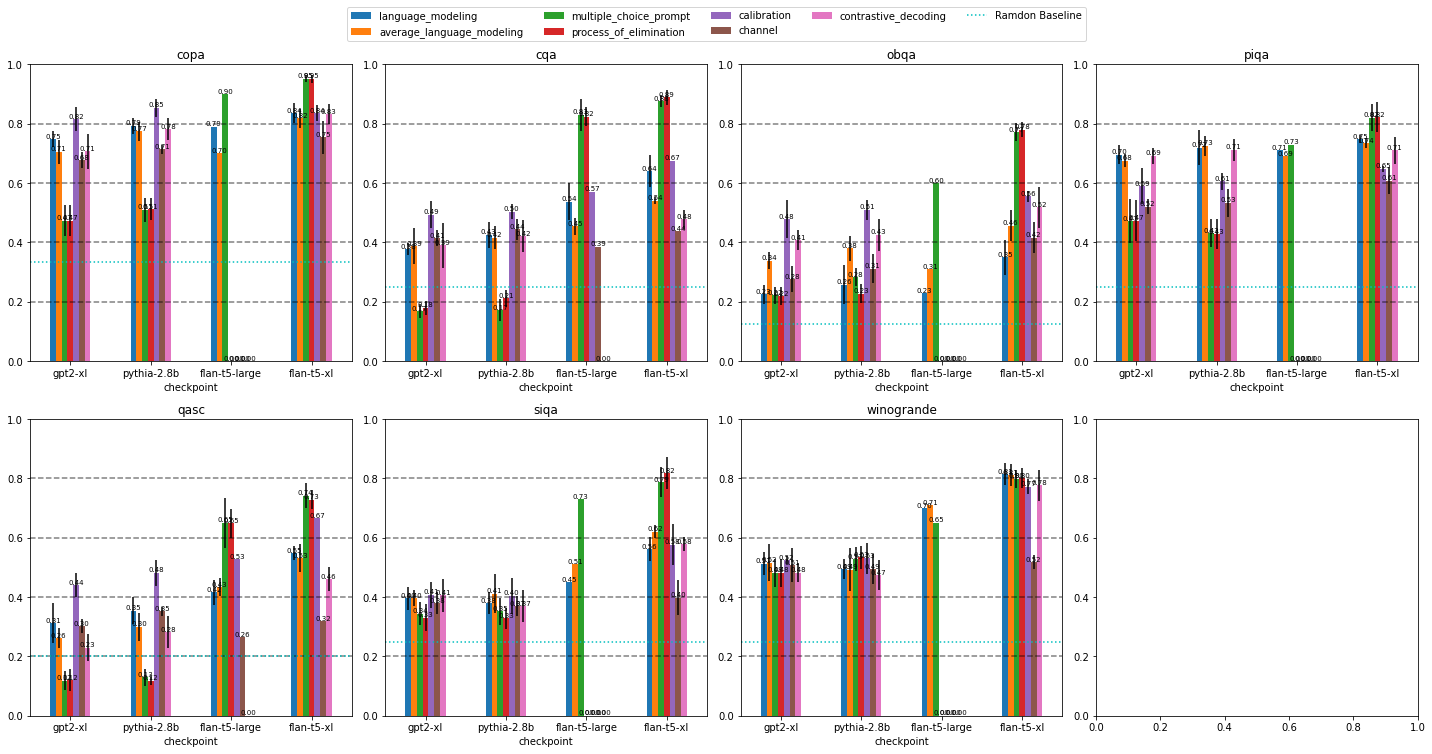

In [4]:
# datasets="anli cqa siqa logical_deduction disambiguation_qa conceptual_combinations strange_stories symbol_interpretation".split()
datasets="copa cqa obqa piqa qasc siqa winogrande".split()
# datasets="disambiguation_qa conceptual_combinations date_understanding emoji_movie ruin_names temporal_sequences code_line_description penguins_in_a_table strange_stories symbol_interpretation tracking_shuffled_objects logical_deduction_three_objects logical_deduction_five_objects logical_deduction_seven_objects".split()
# model_index = ["opt-iml-1.3b", "opt-iml-max-1.3b", "flan-t5-large", "flan-t5-xl"]
model_index = ["gpt2-xl", "pythia-2.8b", "flan-t5-large", "flan-t5-xl"]
method_index = [('accuracy', 'language_modeling'), ('accuracy', 'average_language_modeling'), ('accuracy',    'multiple_choice_prompt'), ('accuracy',    'process_of_elimination')]
method_index += [('accuracy', 'calibration'), ('accuracy', 'channel'), ('accuracy', 'contrastive_decoding')] #('accuracy', 'generate_synonyms')
random_baselines = [1/3, 1/4, 1/8, 1/4, 1/5, 1/4, 1/4, 1/4]
# create subplots for eight datasets
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, dataset in enumerate(datasets):
    ax = axes[i//4][i%4]
    ax.set_ylim([0.0, 1.0])
    h_lines = [0.2, 0.4, 0.6, 0.8]
    data_df = df[(df["dataset"] == dataset) & (df["checkpoint"].isin(model_index))]
    data_df = data_df.groupby(["checkpoint","method"])
    data_means = data_df.mean().unstack().reindex(method_index, axis="columns").reindex(model_index, axis="rows")
    data_errors = data_df.std().unstack().reindex(method_index, axis="columns").reindex(model_index, axis="rows")
    data_means.plot.bar(yerr=data_errors, rot=0, ax=ax, title=dataset, legend=False)
    
    # add accuracy scores to each bar
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.2f' % float(p.get_height()), ha='center', va='bottom', fontsize=7)
    for y in h_lines:
        ax.axhline(y, color="black", linestyle="--", alpha=0.5)
    # plot the random baseline
    ax.axhline(random_baselines[i], color="c", linestyle=":", alpha=1)

# get legends
handles, labels = axes[0][0].get_legend_handles_labels()
labels = [label[label.index(',')+2 : label.index(')')] for label in labels] 
handles += [mlines.Line2D([], [], linestyle=':', color='c', label='Custom Line')]
labels +=["Ramdon Baseline"]
fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))
plt.tight_layout()

# save the figure
plt.savefig("v1.png", dpi=300, bbox_inches='tight')


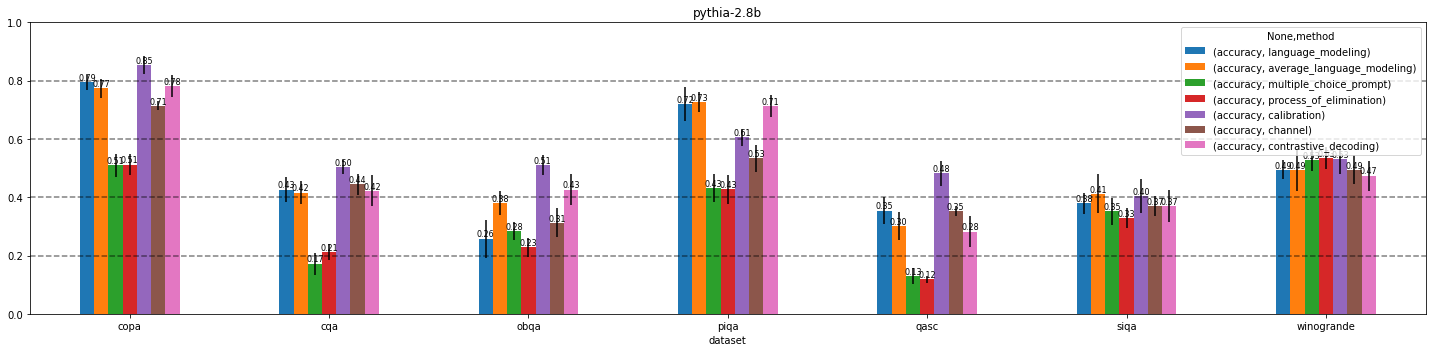

In [5]:
# plot flan-t5-xl on all benchmarks.
# model = "flan-t5-xl"
model = "pythia-2.8b"
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_ylim([0.0, 1.0])
h_lines = [0.2, 0.4, 0.6, 0.8]
# method_index.remove(('accuracy', 'generate_synonyms'))
sing_df = df[(df["dataset"].isin(datasets)) & (df["checkpoint"] == model)]
sing_df = sing_df.groupby(["dataset","method"])
sing_means = sing_df.mean().unstack().reindex(method_index, axis="columns").reindex(datasets, axis="rows")
sing_errors = sing_df.std().unstack().reindex(method_index, axis="columns").reindex(datasets, axis="rows")
sing_means.plot.bar(yerr=sing_errors, rot=0, figsize=(20, 5), title=model, legend=True, ax=ax)
# plot numbers on top of bars
for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%.2f' % float(p.get_height()), ha='center', va='bottom', fontsize=8)
for line in h_lines:
    ax.axhline(line, color="black", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("v2.png", dpi=300, bbox_inches='tight')

IndexError: index 0 is out of bounds for axis 0 with size 0

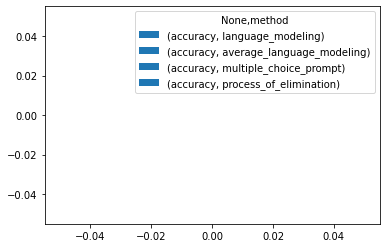

In [6]:
models = ["facebook/opt-iml-1.3b", "facebook/opt-iml-max-1.3b", "google/flan-t5-large", "google/flan-t5-xl"]
method_index = [('accuracy', 'language_modeling'), ('accuracy', 'average_language_modeling'), ('accuracy',    'multiple_choice_prompt'), ('accuracy',    'process_of_elimination')]
anli_df = df[(df["dataset"] == "anli") & (df["checkpoint"].isin(models))]

anli_df = anli_df.groupby(["checkpoint","method"])
anli_means = anli_df.mean().unstack().reindex(method_index, axis="columns")
anli_errors = anli_df.std().unstack().reindex(method_index, axis="columns")

fig, ax = plt.subplots()

anli_means.plot.bar(yerr=anli_errors, ax=ax, capsize=4, rot=0)
# plot horizontal lines corresponding to y labels
# for y in [0.4, 0.5]:
#     ax.axhline(y, color="black", linestyle="--", alpha=0.5)


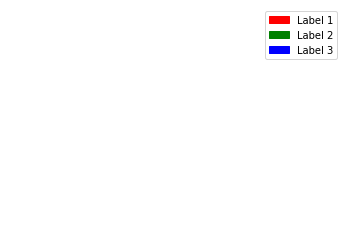

In [140]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create custom legend handles and labels
handles = [
    mpatches.Patch(color='red', label='Red'),
    mpatches.Patch(color='green', label='Green'),
    mpatches.Patch(color='blue', label='Blue')
]
labels = ['Label 1', 'Label 2', 'Label 3']

# Create the legend
plt.legend(handles=handles, labels=labels)

# Hide the axis labels
plt.axis('off')

# Show the plot
plt.show()
